<a href="https://colab.research.google.com/github/ikwak2/hmd/blob/main/notebooks/circor_heart_sound.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The dataset: https://physionet.org/content/circor-heart-sound/1.0.1/

A baseline model: https://github.com/physionetchallenges/python-classifier-2022

In [143]:
!wget -r -N -c -np https://physionet.org/files/circor-heart-sound/1.0.1/

Streaming output truncated to the last 5000 lines.
File ‘physionet.org/files/circor-heart-sound/1.0.1/training_data/85196_AV.tsv’ not modified on server. Omitting download.

--2022-03-02 21:13:05--  https://physionet.org/files/circor-heart-sound/1.0.1/training_data/85196_AV.wav
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 304 Not Modified
File ‘physionet.org/files/circor-heart-sound/1.0.1/training_data/85196_AV.wav’ not modified on server. Omitting download.

--2022-03-02 21:13:05--  https://physionet.org/files/circor-heart-sound/1.0.1/training_data/85196_MV.hea
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 304 Not Modified
File ‘physionet.org/files/circor-heart-sound/1.0.1/training_data/85196_MV.hea’ not modified on server. Omitting download.

--2022-03-02 21:13:05--  https://physionet.org/files/circor-heart-sound/1.0.1/training_data/85196_MV.tsv
Reusing existing connection to physionet.org:443.
H

In [144]:
import os
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
import joblib
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

### Import helper functions from https://github.com/physionetchallenges

In [182]:
!git clone https://github.com/physionetchallenges/python-classifier-2022.git

fatal: destination path 'python-classifier-2022' already exists and is not an empty directory.


In [183]:
import sys
sys.path.insert(0,'/content/python-classifier-2022')

### Tensorflow related

In [185]:
!pip install tensorflow-io

     |████████████████████████████████| 23.4 MB 1.4 MB/s 


In [289]:
import tensorflow as tf
import tensorflow_io as tfio

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [294]:
from IPython.display import Audio

## Parameters

In [148]:
root_dir = '/content/physionet.org/files/circor-heart-sound/1.0.1'
training_data_file = root_dir + '/' + 'training_data.csv'
training_data_dir = root_dir + '/' + 'training_data'
model_dir = root_dir + '/' + 'model'

## Functions

In [328]:
from helper_code import get_age, compare_strings, get_sex, compare_strings
from IPython.core.debugger import set_trace

In [331]:
# Extract features from the data.
# This is defined at originally defined at https://github.com/physionetchallenges/python-classifier-2022/blob/29fdf49efe82b2fff20f0bb685ba71ba858e3171/team_code.py#L136 
# We need to modify this accordingly
def get_features(data, recordings):
    # Extract the age group and replace with the (approximate) number of months for the middle of the age group.
    age_group = get_age(data)

    if compare_strings(age_group, 'Neonate'):
        age = 0.5
    elif compare_strings(age_group, 'Infant'):
        age = 6
    elif compare_strings(age_group, 'Child'):
        age = 6 * 12
    elif compare_strings(age_group, 'Adolescent'):
        age = 15 * 12
    elif compare_strings(age_group, 'Young Adult'):
        age = 20 * 12
    else:
        age = float('nan')

    # Extract sex. Use one-hot encoding.
    sex = get_sex(data)

    sex_features = np.zeros(2, dtype=int)
    if compare_strings(sex, 'Female'):
        sex_features[0] = 1
    elif compare_strings(sex, 'Male'):
        sex_features[1] = 1

    # Extract height and weight.
    height = get_height(data)
    weight = get_weight(data)

    # Extract pregnancy status.
    is_pregnant = get_pregnancy_status(data)

    # Extract recording locations and data. Identify when a location is present, and compute the mean, variance, and skewness of
    # each recording. If there are multiple recordings for one location, then extract features from the last recording.
    locations = get_locations(data)

    set_trace()

    recording_locations = ['AV', 'MV', 'PV', 'TV', 'PhC']
    num_recording_locations = len(recording_locations)
    recording_features = np.zeros((num_recording_locations, 4), dtype=float)
    num_locations = len(locations)
    num_recordings = len(recordings)
    if num_locations==num_recordings:
        for i in range(num_locations):
            for j in range(num_recording_locations):
                if compare_strings(locations[i], recording_locations[j]) and np.size(recordings[i])>0:
                    recording_features[j, 0] = 1
                    recording_features[j, 1] = np.mean(recordings[i])
                    recording_features[j, 2] = np.var(recordings[i])
                    recording_features[j, 3] = sp.stats.skew(recordings[i])
    recording_features = recording_features.flatten()

    features = np.hstack(([age], sex_features, [height], [weight], [is_pregnant], recording_features))

    return np.asarray(features, dtype=np.float32)

IndentationError: ignored

## Exploring the meta data

In [307]:
os.listdir(root_dir)

['training_data',
 'LICENSE.txt',
 'index.html',
 'training_data.csv',
 'model',
 'RECORDS',
 'SHA256SUMS.txt']

In [308]:
df = pd.read_csv(training_data_file)
df

Patient ID    Locations  ... Campaign Additional ID
0          2530  AV+PV+TV+MV  ...   CC2015           NaN
1          9979  AV+PV+TV+MV  ...   CC2015           NaN
2          9983  AV+PV+TV+MV  ...   CC2015           NaN
3         13918  AV+PV+TV+MV  ...   CC2015           NaN
4         14241  AV+PV+TV+MV  ...   CC2015           NaN
..          ...          ...  ...      ...           ...
937       85340  AV+PV+TV+MV  ...   CC2015           NaN
938       85341  AV+PV+TV+MV  ...   CC2015           NaN
939       85343  AV+PV+TV+MV  ...   CC2015           NaN
940       85345        AV+PV  ...   CC2015           NaN
941       85349     AV+PV+TV  ...   CC2015           NaN

[942 rows x 22 columns]

In [309]:
df.describe()

Patient ID      Height      Weight  Additional ID
count    942.000000  826.000000  837.000000     140.000000
mean   66624.319533  110.800242   23.632756   58208.735714
std    16966.858912   30.000607   15.453337   10216.094378
min     2530.000000   35.000000    2.300000   23625.000000
25%    50263.250000   89.000000   12.500000   50092.000000
50%    68452.500000  115.000000   20.400000   50661.500000
75%    84938.500000  133.000000   31.200000   68466.250000
max    85349.000000  180.000000  110.800000   85234.000000

In [310]:
df.columns

Index(['Patient ID', 'Locations', 'Age', 'Sex', 'Height', 'Weight',
       'Pregnancy status', 'Murmur', 'Murmur locations',
       'Most audible location', 'Systolic murmur timing',
       'Systolic murmur shape', 'Systolic murmur grading',
       'Systolic murmur pitch', 'Systolic murmur quality',
       'Diastolic murmur timing', 'Diastolic murmur shape',
       'Diastolic murmur grading', 'Diastolic murmur pitch',
       'Diastolic murmur quality', 'Campaign', 'Additional ID'],
      dtype='object')

In [311]:
# summary of NA's in each column
df.isnull().sum()

Patient ID                    0
Locations                     0
Age                          74
Sex                           0
Height                      116
Weight                      105
Pregnancy status              0
Murmur                        0
Murmur locations            763
Most audible location       763
Systolic murmur timing      764
Systolic murmur shape       764
Systolic murmur grading     764
Systolic murmur pitch       764
Systolic murmur quality     764
Diastolic murmur timing     937
Diastolic murmur shape      937
Diastolic murmur grading    937
Diastolic murmur pitch      937
Diastolic murmur quality    937
Campaign                      0
Additional ID               802
dtype: int64

In [312]:
df.shape

(942, 22)

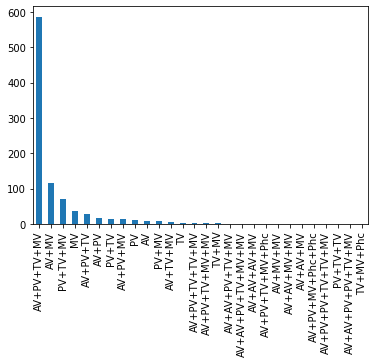

In [313]:
df['Locations'].value_counts().plot.bar()

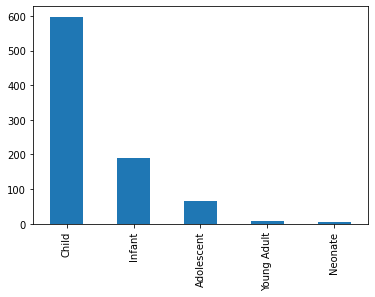

In [314]:
df['Age'].value_counts().plot.bar()

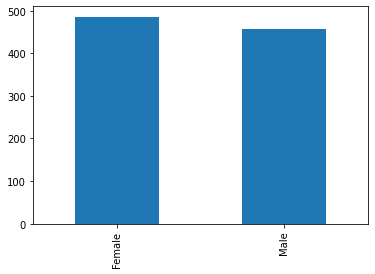

In [315]:
df['Sex'].value_counts().plot.bar()

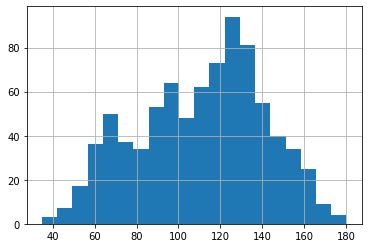

In [316]:
df['Height'].hist(bins = 20)

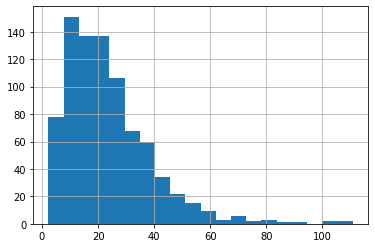

In [317]:
df['Weight'].hist(bins = 20)

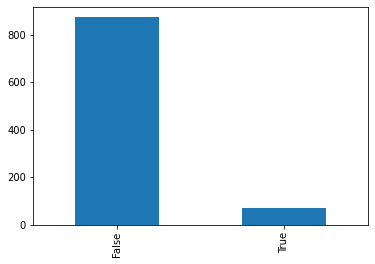

In [318]:
df['Pregnancy status'].value_counts().plot.bar()

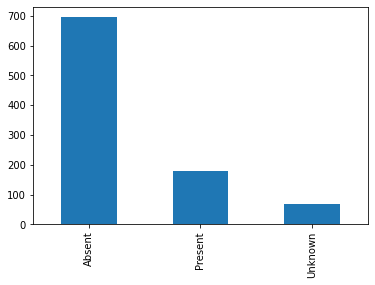

In [319]:
df['Murmur'].value_counts().plot.bar()

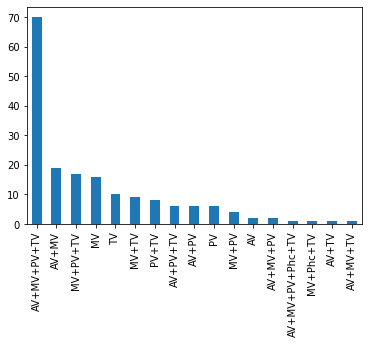

In [320]:
df['Murmur locations'].value_counts().plot.bar()

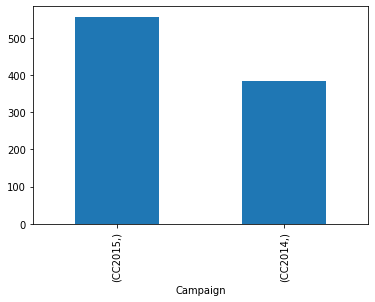

In [321]:
df[['Campaign']].value_counts().plot.bar()

## Prepare features

In [165]:
patient_files = find_patient_files(training_data_dir)
num_patient_files = len(patient_files)

In [166]:
print(f'Number of patient files: {num_patient_files}')

Number of patient files: 942


In [167]:
# Create a folder for the model if it does not already exist.
os.makedirs(model_dir, exist_ok=True)

In [168]:
classes = ['Present', 'Unknown', 'Absent']
num_classes = len(classes)

In [330]:
features = list()
labels = list()
for i in range(num_patient_files):
  print(f'reading {patient_files[i]}')
  current_patient_data = load_patient_data(patient_files[i])
  current_recordings = load_recordings(training_data_dir, current_patient_data) # returns a list of arrays
  current_features = get_features(current_patient_data, current_recordings) # 
  features.append(current_features)
  current_labels = np.zeros(num_classes, dtype=int)
  label = get_label(current_patient_data)
  if label in classes:
    j = classes.index(label)
    current_labels[j] = 1
  labels.append(current_labels)

reading /content/physionet.org/files/circor-heart-sound/1.0.1/training_data/2530.txt
> <ipython-input-329-0d67d1669bef>(43)get_features()
     41     set_trace()
     42 
---> 43     recording_locations = ['AV', 'MV', 'PV', 'TV', 'PhC']
     44     num_recording_locations = len(recording_locations)
     45     recording_features = np.zeros((num_recording_locations, 4), dtype=float)

ipdb> n
> <ipython-input-329-0d67d1669bef>(44)get_features()
     42 
     43     recording_locations = ['AV', 'MV', 'PV', 'TV', 'PhC']
---> 44     num_recording_locations = len(recording_locations)
     45     recording_features = np.zeros((num_recording_locations, 4), dtype=float)
     46     num_locations = len(locations)

ipdb> locations
['AV', 'PV', 'TV', 'MV']
ipdb> exit()


BdbQuit: ignored

In [170]:
features = np.vstack(features)
labels = np.vstack(labels)

## Wave related features

In [300]:
audio, sample_rate = tf.audio.decode_wav(tf.io.read_file('/content/physionet.org/files/circor-heart-sound/1.0.1/training_data/13918_AV.wav'))
audio = tf.squeeze(audio, axis = [-1])

In [301]:
Audio(audio.numpy(), rate = sample_rate)

In [296]:
audio_tensor

<tf.Tensor: shape=(41152,), dtype=float32, numpy=
array([ 0.        ,  0.00100708,  0.00921631, ..., -0.01089478,
       -0.00231934,  0.01565552], dtype=float32)>

In [297]:
audio

<tf.Tensor: shape=(41152, 1), dtype=float32, numpy=
array([[ 0.        ],
       [ 0.00100708],
       [ 0.00921631],
       ...,
       [-0.01089478],
       [-0.00231934],
       [ 0.01565552]], dtype=float32)>

In [261]:
audio.rate.numpy()

16000

In [242]:
import numpy as np
framerate = 44100
t = np.linspace(0,5,framerate*5)
data = np.sin(2*np.pi*220*t) + np.sin(2*np.pi*224*t)
Audio(data,rate=framerate)

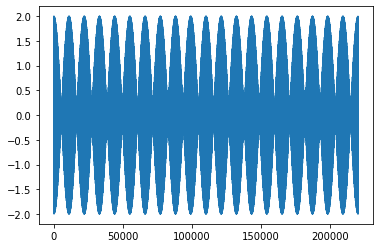

In [245]:
pd.Series(data).plot()

In [247]:
dataleft = np.sin(2*np.pi*220*t)
dataright = np.sin(2*np.pi*224*t)
Audio([dataleft, dataright],rate=framerate)

In [248]:
Audio("http://www.nch.com.au/acm/8k16bitpcm.wav")  # From URL

## Train a random forest classifier

This model only takes the meta data features and does not use any wave features, 

In [171]:
n_estimators = 10    # Number of trees in the forest.
max_leaf_nodes = 100 # Maximum number of leaf nodes in each tree.
random_state = 123   # Random state; set for reproducibility.
cv = 10

imputer = SimpleImputer().fit(features)
features = imputer.transform(features)
model = RandomForestClassifier(n_estimators=n_estimators, max_leaf_nodes=max_leaf_nodes, random_state=random_state)
res = cross_val_score(model, features, labels, cv = cv)

In [172]:
print(f'accuracy of {cv} fold CV: {np.mean(res)}')

accuracy of 10 fold CV: 0.6933482642777155
